In [259]:
import Random
import MathOptInterface
import SCS
using LinearAlgebra
import Plots
using DiffOpt

const MOI = MathOptInterface;

In [260]:
Random.seed!(42)
X = vcat(randn(20, 2), randn(30,2) .+ [3.0,1.5]')
y = append!(ones(20), -ones(30));

In [261]:
penalty = 5.0

5.0

In [262]:
(nobs, nfeat) = size(X)

(50, 2)

In [263]:
model = diff_optimizer(SCS.Optimizer) 
# model = MOI.instantiate(SCS.Optimizer, with_bridge_type=Float64)

Optimizer{MOIB.LazyBridgeOptimizer{MOIU.CachingOptimizer{SCS.Optimizer,MOIU.UniversalFallback{MOIU.Model{Float64}}}}}

In [264]:
l = MOI.add_variables(model, nobs)
w = MOI.add_variables(model, nfeat)
b = MOI.add_variable(model)

t = MOI.add_variable(model)  # extra variable for the SOC constraint

MathOptInterface.VariableIndex(54)

In [265]:
MOI.add_constraint(
    model,
    MOI.VectorAffineFunction(
        MOI.VectorAffineTerm.(1:nobs, MOI.ScalarAffineTerm.(1.0, l)), zeros(nobs)
    ), 
    MOI.Nonnegatives(nobs)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.Nonnegatives}(1)

In [266]:
MOI.add_constraint(
    model,
    MOI.VectorAffineFunction([MOI.VectorAffineTerm(1, MOI.ScalarAffineTerm(-1.0, t))], [√penalty]),
    MOI.Zeros(1)
)

pen_const = MOI.add_constraint(
    model, 
    MOI.VectorAffineFunction(MOI.VectorAffineTerm.(1:(nfeat+2), MOI.ScalarAffineTerm.(1.0, vcat(t, w,b))), zeros(nfeat+2)), 
    MOI.SecondOrderCone(nfeat + 2)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.SecondOrderCone}(3)

In [267]:
for i in 1:nobs
    MOI.add_constraint(
        model,
        MOI.ScalarAffineFunction(MOI.ScalarAffineTerm.([1.0; y[i]*X[i,:]; y[i]], [l[i]; w; b]), 0.0),
        MOI.GreaterThan(1.0)
    )
end

In [268]:
objective_function = MOI.ScalarAffineFunction(
                        MOI.ScalarAffineTerm.(ones(nobs), l),
                        0.0
                    )
MOI.set(model, MOI.ObjectiveFunction{MOI.ScalarQuadraticFunction{Float64}}(), objective_function)
MOI.set(model, MOI.ObjectiveSense(), MOI.MIN_SENSE)

In [269]:
MOI.optimize!(model)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 255, CG tol ~ 1/iter^(2.00)
eps = 1.00e-005, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 54, constraints m = 105
Cones:	primal zero / dual free vars: 1
	linear vars: 100
	soc vars: 4, soc blks: 1
Setup time: 1.52e-004s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|5.13e+019 1.64e+020 1.00e+000 -1.69e+021 2.57e+021 1.08e+021 6.16e-005 
    80|2.29e-006 3.92e-006 1.09e-006 5.58e+000 5.58e+000 1.02e-015 2.15e-003 
--------------------------------------

In [270]:
loss = MOI.get(model, MOI.ObjectiveValue())
λ = MOI.get(model, MOI.ConstraintDual(), pen_const)[1]
wv = MOI.get(model, MOI.VariablePrimal(), w)
bv = MOI.get(model, MOI.VariablePrimal(), b)

1.7465540072946883

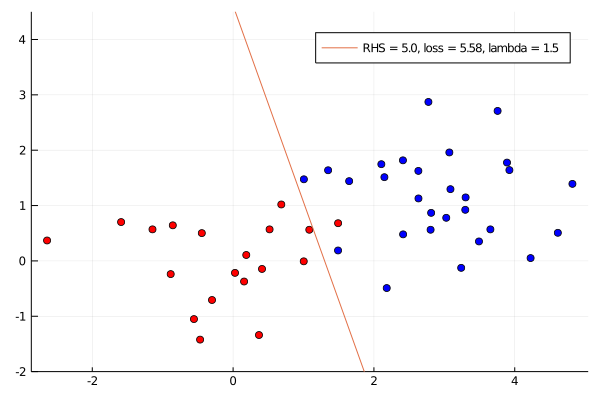

In [271]:
p = Plots.scatter(X[:,1], X[:,2], color = [yi > 0 ? :red : :blue for yi in y], label = "")
Plots.yaxis!(p, (-2, 4.5))
Plots.plot!(p, [0.0, 2.0], [-bv / wv[2], (-bv - 2wv[1])/wv[2]], label = "RHS = $(penalty), loss = $(round(loss, digits=2)), lambda = $(round(λ, digits=2))")

In [275]:
wv'wv + bv*bv <= penalty

true

In [255]:
x = model.primal_optimal
s = MOI.get(model, MOI.ConstraintPrimal(), model.con_idx)
y = model.dual_optimal;

dA = zeros(nobs+nfeat+1, nobs+nfeat+1+1)
db = zeros(2*(nobs+nfeat+1) + 1)
# db[nobs+1] = 1.0   # only weighing the penalty constraint i.e. √penalty = t 
dc = zeros(nobs+nfeat+1+1) # 1 for `b` and 1 for extra var `t`

dx, dy, ds = backward_conic!(model, dA, db, dc)

MethodError: MethodError: no method matching load_variables(::SCS.Optimizer, ::Int64)
Closest candidates are:
  load_variables(!Matched::Union{AbstractModelLike{T}, AbstractOptimizer{T}} where T, ::Any) at C:\Users\Pika\.julia\packages\MathOptInterface\k7UUH\src\Utilities\model.jl:719
  load_variables(!Matched::MathOptInterface.Utilities.MockOptimizer, ::Any) at C:\Users\Pika\.julia\packages\MathOptInterface\k7UUH\src\Utilities\mockoptimizer.jl:562